In [4]:
# Imports
import pandas as pd
import numpy as np
import csv
import re
import sklearn
import sklearn.datasets
import sklearn.linear_model

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import ensemble

np.random.seed(42)
plt.style.use('fivethirtyeight')
sns.set()
sns.set_context("talk")

# Set some parameters
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 16
np.set_printoptions(4)

# We will use plot_3d helper function to help us visualize gradients
from hw7_utils import plot_3d

%matplotlib inline

In [5]:
import seaborn as sns

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 3
sns.set() 

In [6]:
df = pd.read_csv('nba.csv')
df["WON"] = df["WL"]
df["WON"] = df["WON"].replace("W", 1)
df["WON"] = df["WON"].replace("L", 0)
df.head(5)

SEASON_ID     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME   GAME_ID  \
0      22018  1610612744               GSW   Golden State Warriors  21800002   
1      22018  1610612760               OKC   Oklahoma City Thunder  21800002   
2      22018  1610612755               PHI      Philadelphia 76ers  21800001   
3      22018  1610612738               BOS          Boston Celtics  21800001   
4      22018  1610612750               MIN  Minnesota Timberwolves  21800010   

    GAME_DATE      MATCHUP WL  MIN  FGM  ...  REB  AST  STL  BLK  TOV  PF  \
0  2018-10-16  GSW vs. OKC  W  240   42  ...   58   28    7    7   21  29   
1  2018-10-16    OKC @ GSW  L  240   33  ...   45   21   12    6   15  21   
2  2018-10-16    PHI @ BOS  L  240   34  ...   47   18    8    5   16  20   
3  2018-10-16  BOS vs. PHI  W  240   42  ...   55   21    7    5   15  20   
4  2018-10-17    MIN @ SAS  L  240   39  ...   46   20    9    2   11  27   

   PTS  PLUS_MINUS  VIDEO_AVAILABLE  WON  
0  108           8                1    1  
1  100          -8                1    0  
2   87         -18                1    0  
3  105          18                1    1  
4  108          -4                1    0  

[5 rows x 30 columns]

## Creating a 1D Logistic Regression Model

Our predictions represented the probability that the observation belonged to a specific category, which is whether or not the team won. $\hat{y} = P(Y = 1 | x)$, where $Y = 1$ indicates that the team we're observing won the game.

### Implementing Logistic Regression

The prediction of our model is $ \hat{y} = \sigma(x \hat{\theta})$. _Note: Here, both $x$ and $\hat{\theta}$ are scalars, not vectors._ 

We'll start by trying to build a model that predicts the winning probability as a function of the number of points that a team scored.

`sigma` = sigmoid function
`predicted_probability_of_winning_given_pts` --> returns the correct prediction

In [8]:
import math
def sigma(t):
    return 1/(1+np.exp(-t))

def predicted_probability_of_winning_given_features(X, theta):
    return sigma(X @ theta)

In [9]:
#adding a bias term (intercept term) so our model performs better

points_and_bias = df[["PTS"]].copy()
points_and_bias["bias"] = np.ones(len(points_and_bias))
points_and_bias.head()

PTS  bias
0  108   1.0
1  100   1.0
2   87   1.0
3  105   1.0
4  108   1.0

## Optimizing Logistic Regresion

We will now find the optimal theta $\hat{\theta}$ for our given data by both minimizing MSE and cross entropy loss

### Calculating MSE

`mse_for_model_on_NBA_data(theta)` takes in a value of $\theta$ and returns the MSE on the NBA dataset.

In [12]:
def mse(y_obs, y_hat):
    return np.mean((y_obs - y_hat)**2)

def mse_for_model_on_NBA_data(theta):
    return mse(df["WON"], predicted_probability_of_winning_given_features(points_and_bias, theta))

### Plotting MSE

The surface has a huge almost completely flat region. This means this loss function is very difficult to optimize.

In [14]:
import plotly.graph_objects as go

num_points = 50 # increase for better resolution, but it will run more slowly. 

if (num_points <= 100):

    uvalues = np.linspace(-0.3, 0.3, num_points)
    vvalues = np.linspace(-20, 20, num_points)
    (u,v) = np.meshgrid(uvalues, vvalues)
    thetas = np.vstack((u.flatten(),v.flatten()))

    MSE = np.array([mse_for_model_on_NBA_data(t) for t in thetas.T])

    loss_surface = go.Surface(x=u, y=v, z=np.reshape(MSE, u.shape))

    fig = go.Figure(data=[loss_surface])
    fig.update_layout(scene = dict(
        xaxis_title = "theta0",
        yaxis_title = "theta1",
        zaxis_title = "MSE"))
    fig.show()
else:
    print("Too many points. Choose smaller number of points so code can run.")

### Minimizing MSE

In [15]:
from scipy.optimize import minimize

optimal_theta = minimize(mse_for_model_on_NBA_data, [0, 0])
theta_hat_1 = optimal_theta.x[0]
theta_hat_2 = optimal_theta.x[1]

We will convert our logistic regression model into a concrete prediction by thresholding. That is, if our $\hat{y} \geq 0.5$, we say our prediction is that the team will win; otherwise, we say that we predict that we will lose. A simple way to do this is just to round our $\hat{y}$.

In [17]:
y_hat = predicted_probability_of_winning_given_features(points_and_bias, np.array([theta_hat_1, theta_hat_2])) 
games_and_predictions = df.copy()
games_and_predictions["predicted_to_win"] = np.round(y_hat)
games_and_predictions[["TEAM_NAME", "GAME_DATE", "WON", "predicted_to_win"]].tail(5)

TEAM_NAME   GAME_DATE  WON  predicted_to_win
2455         Denver Nuggets  2019-04-10    1               0.0
2456          Orlando Magic  2019-04-10    1               1.0
2457      Charlotte Hornets  2019-04-10    0               1.0
2458      Memphis Grizzlies  2019-04-10    1               1.0
2459  Golden State Warriors  2019-04-10    0               1.0

To evaluate the quality of our model, we will compute the fraction of the rows of the table for which our model was able to correctly predict the outcome of the game based on only the points scored by one team.

In [18]:
percentage_correct = len(games_and_predictions[games_and_predictions["WON"] == games_and_predictions["predicted_to_win"]])/len(games_and_predictions)
percentage_correct

0.7109756097560975

The surface for our MSE had a huge almost completely flat region, which means that the loss function is very difficult to optimize.

We will use an alternate loss function called the cross-entropy loss instead that will yield a much nicer loss surface (no big flat regions). `cel(y_obs, y_hat)` calculates the cross-entropy loss betweeen `y_obs` and `y_hat`. `cel_for_model_on_NBA_data(theta)` takes in a value of $\vec{{\theta}}$ and returns the cross-entropy loss on the dataset.

In [19]:
def cel(y_obs, y_hat):
    return -np.mean(y_obs*np.log(y_hat) + (1-y_obs) * np.log(1-y_hat))

def cel_for_model_on_NBA_data(theta):
    return cel(df["WON"], predicted_probability_of_winning_given_features(points_and_bias, theta))

### Plotting Cross-Entropy Loss

In [20]:
import plotly.graph_objects as go

num_points = 50 # increase for better resolution, but it will run more slowly. 

if (num_points <= 100):

    uvalues = np.linspace(-0.3, 0.3, num_points)
    vvalues = np.linspace(-20, 20, num_points)
    (u,v) = np.meshgrid(uvalues, vvalues)
    thetas = np.vstack((u.flatten(),v.flatten()))

    CEL = np.array([cel_for_model_on_NBA_data(t) for t in thetas.T])

    loss_surface = go.Surface(x=u, y=v, z=np.reshape(CEL, u.shape))

    fig = go.Figure(data=[loss_surface])
    fig.update_layout(scene = dict(
        xaxis_title = "theta0",
        yaxis_title = "theta1",
        zaxis_title = "CEL"))
    fig.show()
else:
    print("Too many points. Choose smaller number of points so code can run.")

/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning:

divide by zero encountered in log



## Higher Dimensional Models

Now we will kick it up a notch amd try training a logistic regression model on all useful fields.

In [21]:
useful_numeric_fields = df.loc[:, 'FGM':'PTS'].copy()
useful_numeric_fields["BIAS"] = np.ones(len(useful_numeric_fields))
useful_numeric_fields.head(5)

FGM  FGA  FG_PCT  FG3M  FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  \
0   42   95   0.442     7    26    0.269   17   18   0.944    17    41   58   
1   33   91   0.363    10    37    0.270   24   37   0.649    16    29   45   
2   34   87   0.391     5    26    0.192   14   23   0.609     6    41   47   
3   42   97   0.433    11    37    0.297   10   14   0.714    12    43   55   
4   39   91   0.429     6    19    0.316   24   27   0.889    14    32   46   

   AST  STL  BLK  TOV  PF  PTS  BIAS  
0   28    7    7   21  29  108   1.0  
1   21   12    6   15  21  100   1.0  
2   18    8    5   16  20   87   1.0  
3   21    7    5   15  20  105   1.0  
4   20    9    2   11  27  108   1.0

### Optimizing our Model

`theta_19_hat` is a numpy array of length 19 that minimizes the MSE.

In [23]:
def mse_for_model_on_full_data(theta):
    return mse(df["WON"], predicted_probability_of_winning_given_features(useful_numeric_fields, theta))

In [24]:
theta_19_hat = minimize(mse_for_model_on_full_data, np.zeros(19)).x
mse_for_model_on_full_data(theta_19_hat)

0.10736591571796995

`frac_19_correct` is equal to the fraction of predictions which are correct given this new model.

In [25]:
y_hat = np.round(predicted_probability_of_winning_given_features(useful_numeric_fields, theta_19_hat))
frac_19_correct = len(df[df["WON"] == y_hat])/len(df)
frac_19_correct

0.8434959349593496

In [26]:
pd.Series(theta_19_hat, index = useful_numeric_fields.columns).sort_values(ascending = False)

BIAS        5.191449
FG3_PCT     2.725184
FGM         2.123860
FT_PCT      2.108145
FG3M        0.923039
FTM         0.882696
STL         0.387256
DREB        0.325504
OREB        0.304814
BLK         0.069643
REB         0.048715
AST         0.019556
FG3A       -0.003555
PF         -0.055789
FTA        -0.071648
TOV        -0.311187
FGA        -0.451155
PTS        -0.754584
FG_PCT    -21.898362
dtype: float64

_From the series above, we can clearly see that the attributes with the biggest positive effect on a team's success are the BIAS factor, FG3_PCT, FGM (field goals made), and FT_PCT (percentage of free throws made). The attributes with the biggest negative effect on a team's success are FG_PCT (percentage of field goals made) and PTS (points). This was very surprising to me because I always assumed the amount of points a team usually gets and how well they throw would be in the team's favor, not against them. The fact that BIAS is the biggest positive factor is trivial, since it was introduced arbitrarily._

## Using Decision Trees and Random Forests to Model NBA Data

We will now train a multi-class classifier with three different models (one-vs-rest logistic regression, decision tree, random forest) and compare the accuracies and decision boundaries created by each. 

In [29]:
nba_data = pd.read_csv("nba18-19.csv")
nba_data.head(5)

Rk                  Player Pos  Age   Tm   G  GS    MP   FG   FGA  ...  \
0   1  Álex Abrines\abrinal01  SG   25  OKC  31   2  19.0  1.8   5.1  ...   
1   2      Quincy Acy\acyqu01  PF   28  PHO  10   0  12.3  0.4   1.8  ...   
2   3  Jaylen Adams\adamsja01  PG   22  ATL  34   1  12.6  1.1   3.2  ...   
3   4  Steven Adams\adamsst01   C   25  OKC  80  80  33.4  6.0  10.1  ...   
4   5   Bam Adebayo\adebaba01   C   21  MIA  82  28  23.3  3.4   5.9  ...   

     FT%  ORB  DRB  TRB  AST  STL  BLK  TOV   PF   PTS  
0  0.923  0.2  1.4  1.5  0.6  0.5  0.2  0.5  1.7   5.3  
1  0.700  0.3  2.2  2.5  0.8  0.1  0.4  0.4  2.4   1.7  
2  0.778  0.3  1.4  1.8  1.9  0.4  0.1  0.8  1.3   3.2  
3  0.500  4.9  4.6  9.5  1.6  1.5  1.0  1.7  2.6  13.9  
4  0.735  2.0  5.3  7.3  2.2  0.9  0.8  1.5  2.5   8.9  

[5 rows x 30 columns]

Our goal will be to predict a player's position given several other features. The 5 positions in basketball are PG, SG, SF, PF, and C (which stand for point guard, shooting guard, small forward, power forward, and center). This information is contained in the `Pos` column.

In [30]:
nba_data['Pos'].value_counts()

SG       176
PF       147
PG       139
C        120
SF       118
PF-SF      2
SF-SG      2
C-PF       1
SG-PF      1
PF-C       1
SG-SF      1
Name: Pos, dtype: int64

We will categorize players into 1 of 3 categories: **guard**, **forward**, and **center**. The below code will take the `Pos` column of our dataframe and use it to create a new column `Pos3` that consist of values G, F, and C (which stand for guard, forward, and center).

In [31]:
def basic_position(pos):
    if 'F' in pos:
        return 'F'
    elif 'G' in pos:
        return 'G'
    return 'C'

nba_data['Pos3'] = nba_data['Pos'].apply(basic_position)
nba_data['Pos3'].value_counts()

G    315
F    273
C    120
Name: Pos3, dtype: int64

Let's restrict our data to only contain rows for players that averaged 10 or more points per game for cleaner visualizations.

In [32]:
nba_data = nba_data[nba_data['PTS'] > 10]

Scatterplot of Rebounds (`TRB`) vs. Assists (`AST`).

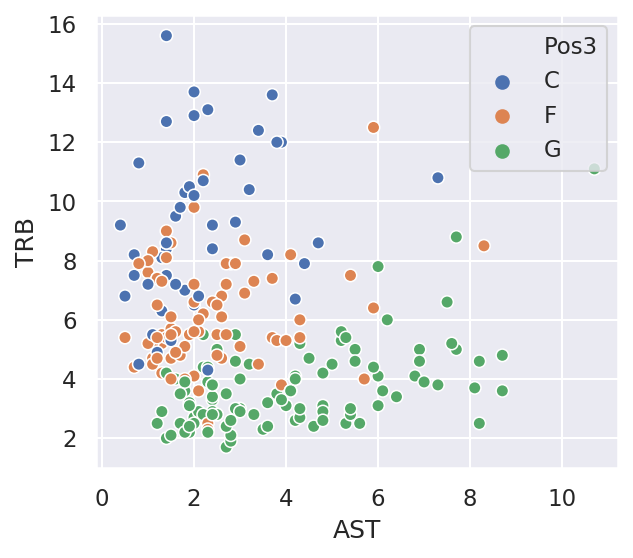

In [33]:
sns.scatterplot(data = nba_data, x = 'AST', y = 'TRB', hue = 'Pos3');

We can see that there's some pretty decent clustering between our 3 categories of forward, center, and guard.

## Evaluating Split Quality

We will explore different ways to evaluate split quality for classification and regression trees in this question.

Entropy S of a node is:

$$ S = -\sum_{C} p_C \log_{2} p_C $$

where $p_C$ is the proportion of data points in a node with label $C$. This function will help us determine the unpredictability of a node in a decision tree. 


In [34]:
def entropy(labels):
    length = len(labels)
    props = pd.Series(labels).value_counts()/len(labels)
    for i in range(len(props)):
        props[i] = props[i]*np.log2(props[i])
    return -1*sum(props)
        
entropy(nba_data['Pos3'])

1.5215555679560269

### Question 1b

The decision tree visualizations have a `gini` parameter. This is the node's Gini impurity, which is the chance that a sample would be misclassified if randomly assigned at this point. 

We can calculate the Gini impurity of a node with the formula ($p_C$ is the proportion of data points in a node with label $C$):

$$ G = 1 - \sum_{C} {p_C}^2 $$

In [35]:
def gini_impurity(labels):
    length = len(labels)
    props = (pd.Series(labels).value_counts()/len(labels))**2
    return 1-sum(props)

gini_impurity(nba_data['Pos3'])

0.6383398017253514

It usually does not make sense to use entropy and Gini impurity for regression trees because the response variable is continuous. However, we can use the variance of the response values in a node as an alternative to entropy and Gini impurity. Recall that the variance is defined as:

$$ \sigma^2 = \frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2 $$

where $\mu$ is the mean, $N$ is the total number of data points, and $x_i$ is the value of each data point.


In [36]:
def variance(values):
    total = 0
    N = len(values)
    mu = np.mean(values)
    for i in range(N):   
        total = total + (values.iloc[i] - mu)**2
    return (1/N)*total
        
    
variance(nba_data['PTS'])

21.02314826358863

### Weighted Entropy 

Weighted entropy is given by:

$$ L = \frac{N_1 S(X) + N_2 S(Y)}{N_1 + N_2} $$

$N_1$ is the number of samples in the left node $X$, and $N_2$ is the number of samples in the right node $Y$. This notion of a weighted average can be extended to other metrics such as Gini impurity and variance simply by changing the $S$ (entropy) function to $G$ (Gini impurity) or $\sigma^2$ (variance).

In [37]:
def weighted_metric(left, right, metric):
    N1 = len(left)
    N2 = len(right)
    return ((N1*metric(left)) + (N2*metric(right)))/(N1 + N2)

we_pos3_age_30 = weighted_metric(nba_data[nba_data["Age"]>=30]["Pos3"],nba_data[nba_data["Age"]<30]["Pos3"],entropy)
we_pos3_age_30

1.521489768014793

## Classification

Let's switch gears to classification with the NBA dataset.

## One-vs-Rest Logistic Regression

Let's first split `nba_data` into a training set and test set.

In [38]:
nba_train, nba_test = train_test_split(nba_data, test_size=0.25, random_state=100)
nba_train = nba_train.sort_values(by='Pos')
nba_test = nba_test.sort_values(by='Pos')

### Question 2a

We will fit our one-vs-rest model using the `AST` and `TRB` columns (in that order) from `nba_train` as our features, and `Pos3` as our response variable.


In [39]:
logistic_regression_model = LogisticRegression(multi_class = "ovr")
logistic_regression_model.fit(nba_train[["AST", "TRB"]], nba_train["Pos3"])

LogisticRegression(multi_class='ovr')

In [40]:
nba_train['Predicted (OVRLR) Pos3'] = logistic_regression_model.predict(nba_train[['AST', 'TRB']])
nba_train[['AST', 'TRB', 'Pos3', 'Predicted (OVRLR) Pos3']].head(15)

AST   TRB Pos3 Predicted (OVRLR) Pos3
655  1.4   8.6    C                      C
644  2.0  10.2    C                      C
703  0.8   4.5    C                      F
652  1.6   7.2    C                      F
165  1.4   7.5    C                      C
122  2.4   8.4    C                      C
353  7.3  10.8    C                      C
367  1.4   8.6    C                      C
408  1.2   4.9    C                      F
161  3.9  12.0    C                      C
647  3.4  12.4    C                      C
308  4.2   6.7    C                      G
362  3.0  11.4    C                      C
146  3.6   8.2    C                      C
233  4.4   7.9    C                      C

In [41]:
lr_training_accuracy = logistic_regression_model.score(nba_train[['AST', 'TRB']], nba_train['Pos3'])
lr_training_accuracy

0.7964071856287425

In [42]:
lr_test_accuracy = logistic_regression_model.score(nba_test[['AST', 'TRB']], nba_test['Pos3'])
lr_test_accuracy

0.6428571428571429

Let's draw the decision boundary for this logistic regression classifie and see how the classifier performs on both the training and test data.

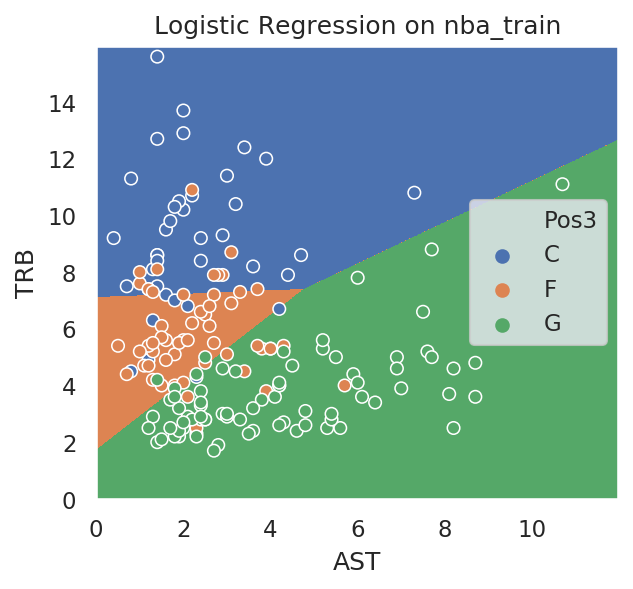

In [43]:
sns_cmap = ListedColormap(np.array(sns.color_palette())[0:3, :])

xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = logistic_regression_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_train, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Logistic Regression on nba_train');

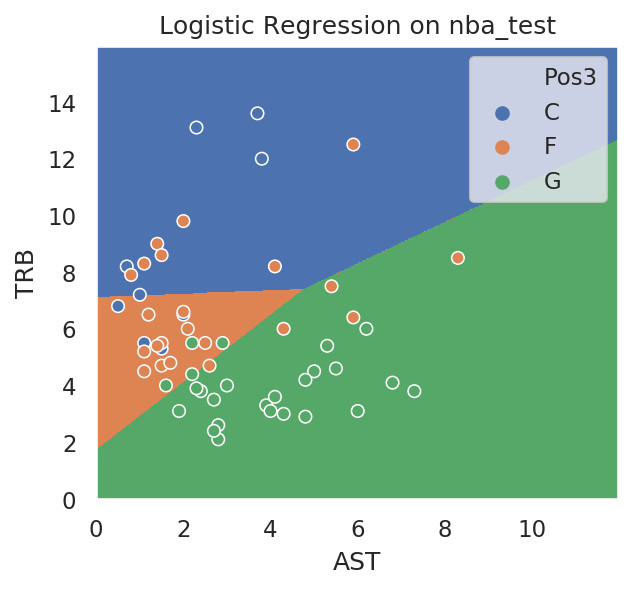

In [44]:
sns_cmap = ListedColormap(np.array(sns.color_palette())[0:3, :])

xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = logistic_regression_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_test, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Logistic Regression on nba_test');

Our one-vs-rest logistic regression was able to find a linear decision boundary between the three classes. It generally classifies centers as players with a lot of rebounds, forwards as players with a medium number of rebounds and a low number of assists, and guards as players with a low number of rebounds. 

## Decision Trees

Let's now create a decision tree classifier on the same training data `nba_train`, and look at the resulting decision boundary. 

In [45]:
decision_tree_model = tree.DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(nba_train[['AST', 'TRB']], nba_train['Pos3'])

DecisionTreeClassifier(random_state=42)

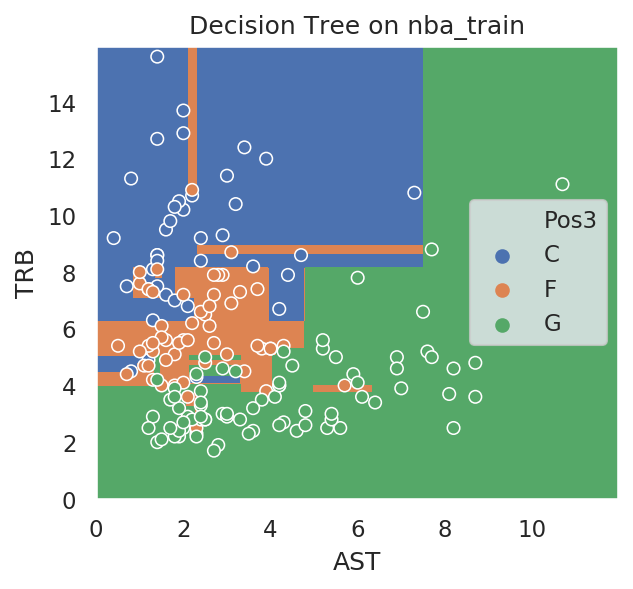

In [46]:
xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = decision_tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_train, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Decision Tree on nba_train');

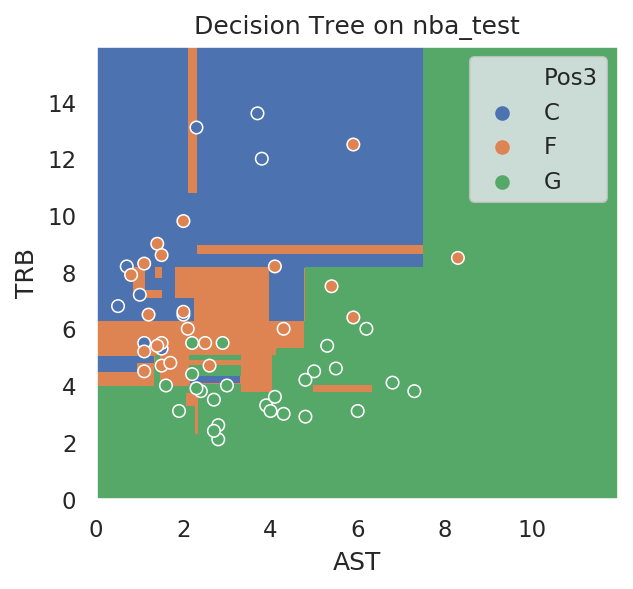

In [47]:
xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = decision_tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_test, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Decision Tree on nba_test');

Let's set `dt_training_accuracy` to be the training accuracy of the decision tree model and `dt_test_accuracy` to be the test accuracy.

In [48]:
dt_training_accuracy = decision_tree_model.score(nba_train[['AST', 'TRB']], nba_train['Pos3'])
dt_test_accuracy = decision_tree_model.score(nba_test[['AST', 'TRB']], nba_test['Pos3'])
dt_training_accuracy, dt_test_accuracy

(0.9940119760479041, 0.6428571428571429)

## Random Forests

Let's now create a random forest classifier on the same training data `nba_train` and look at the resulting decision boundary. 

In [49]:
random_forest_model = ensemble.RandomForestClassifier(n_estimators = 20, random_state = 42)
random_forest_model.fit(nba_train[['AST', 'TRB']], nba_train['Pos3'])

RandomForestClassifier(n_estimators=20, random_state=42)

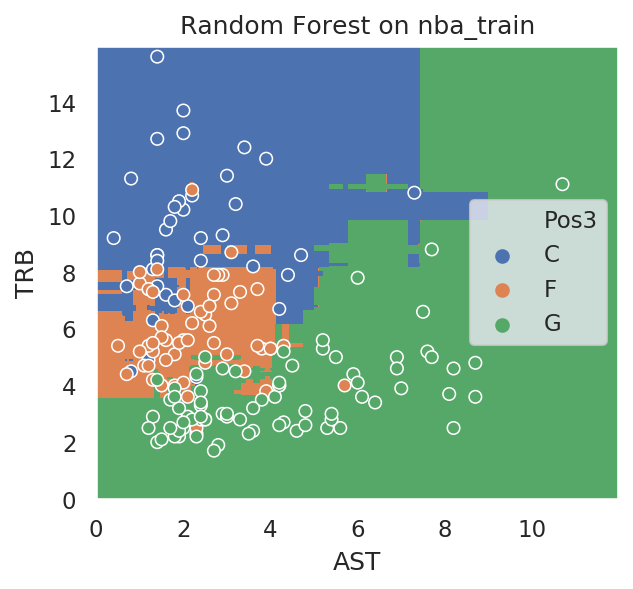

In [50]:
xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = random_forest_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_train, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Random Forest on nba_train');

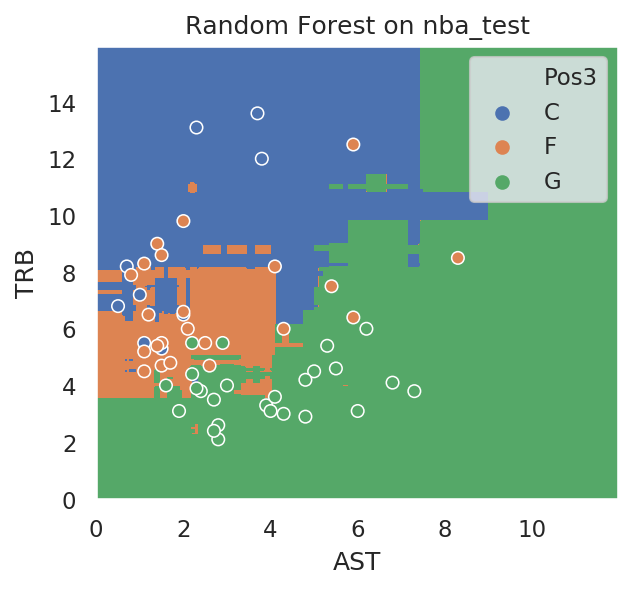

In [51]:
xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = random_forest_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_test, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Random Forest on nba_test');

Let's set `rf_train_accuracy` to be the training accuracy of the random forest model and `rf_test_accuracy` to be the test accuracy.

In [52]:
rf_train_accuracy = random_forest_model.score(nba_train[['AST', 'TRB']], nba_train['Pos3'])
rf_test_accuracy = random_forest_model.score(nba_test[['AST', 'TRB']], nba_test['Pos3'])
rf_train_accuracy, rf_test_accuracy

(0.9760479041916168, 0.7142857142857143)

## Summary of Training and Test Accuracies for our 3 Models

Below is a summary of the training and test accuracies for the three models you created (multiclass one-vs-rest logistic regression, decision tree, random forest).

In [53]:
train_accuracy = [lr_training_accuracy, lr_test_accuracy, dt_training_accuracy, dt_test_accuracy, rf_train_accuracy, rf_test_accuracy]
index = ['OVR Logistic Regression', 'Decision Tree', 'Random Forest']
df = pd.DataFrame([(lr_training_accuracy, lr_test_accuracy), 
                   (dt_training_accuracy, dt_test_accuracy),
                   (rf_train_accuracy, rf_test_accuracy)], 
                  columns=['Training Accuracy', 'Test Accuracy'], index=index)
df.plot.bar();

_The model that performed the best on the training set was the Decision Tree model, and the model that performed the best on the test set was the Random Forest model. The training and test accuracy are related because for the models that had very high training accuracy but low test accuracy, the culprit was possibly the very exact boundaries it draws for the data, leading to extreme overfitting of the training data. This was likely the case for the Decision Tree model. The Random Forest model is a type of Decision Tree, so it can still draw very accurate boundaries for the training set. However, since it draws multiple trees with different samples and different features, we were able to generate enough variance and avoid overfitting our test data as much._